# Экспериментальное исследование алгоритмов для регулярных запросов

### Постановка задачи

В данной работе исследуются следующие задачи достижимости, решаемые в предыдущих работах.
1) Достижимость между всеми парами вершин.
2) Достижимость для каждой из заданного множества стартовых вершин.

Таким образом целью работы является анализ производительности алгоритма решения задачи достижимости между всеми парами вершин и с заданным множеством стартовых вершин с регулярными ограничениями.

Для достижения поставленной цели необходимо ответить на следующие вопросы.
1) Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
2) Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?



### Описание исследуемых решений

В ходе эксперемента будет применен алгоритм достижимости с регулярными ограничениями с несколькими стартовыми вершинами, основанный на multiple source BFS через линейную алгебру.
Найти его можно в `project.reachability` и он представляет собой следующую сигнатуру: 

```python
def ms_bfs_based_rpq(regex: str, graph: MultiDiGraph, start_nodes: set[int],
         final_nodes: set[int]) -> set[tuple[int, int]]
```

### Описание набора данных для экспериментов
#### Графы
Использовались следующие графы из [набора](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/index.html):
- [skos](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/skos.html#skos) - 144 вершин, 252 ребра.
- [core](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/core.html#core) - 1323 вершины, 2752 ребра.
- [pathways](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/pathways.html#pathways) - 6238 вершин, 12363 ребра.

В этом эксперименте происходит изучение работы графов с различной структурой.
Благодаря этому можно получить данные о влиянии количества вершин и ребер на производительность.
Однако, при работе с большими графами время, затрачиваемое на 
проверку достижимости для каждой вершины из заданного множества, оказалось слишком высоким на имеющемся оборудовании. Это является следствием количества матричных умножений, которых при решении задачи для каждой вершины получается больше. Поэтому было принято решение оставить один граф(pathways), количество ребер и вершин которого сильно больше чем у двух других. Графы skos и core были выбраны потому, что они малы относительно pathways и анализ их производительности занимает приемлемое время. Кроме того, графы можно поделить на малый (skos), средний(core) и большой(pathways), что даст возможность отследить зависимость работы от увеличения графа.

#### Регулярные запросы
Использовались следующие регулярные запросы к графам:
- (l1 l2)*|(l0 l3)
- (l1 | l2)* l3
- (l3 | l0) l1*
- l1 l2 l3 (l0 | l1)*,

l представляет собой наиболее часто встречающиеся метки на рёбрах.

### Описание эксперимента
#### Оборудование
ОС: Ubuntu 20.04.4

Процессор: 11th Gen Intel(R) Core(TM) i3-1115G4 @ 3.00GHz

Оперативная память: 8 ГБ.

Версия Python: 3.10.12
#### Подробности проведения замеров

**1 вопрос.**
Для определения того, какое представление разреженных матриц и векторов является лучшим для каждой из задач, было решено
измерить скорость работы алгоритмов на выбранных графах с указанными выше регулярными ограничениями при фиксированном наборе
стартовых вершин на следующих представлениях разреженных матриц: [dok_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html#scipy.sparse.dok_matrix),
[lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix),
[csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html#scipy.sparse.csc_matrix),
[csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix).

**2 вопрос.** Для определения того, при каких размерах стартового множества становится выгоднее решать задачу для всех пар
и выбирать нужные, было решено зафиксировать представление матрицы и изменять значение стартовых вершин на графах, применяя
к ним указанные выше регулярные запросы.

Каждый замер проводился 5 раз и выводилось его среднее значение со стандартным отклонением.

### Постановка экспериментов

Для начала импортируем все необходимое.

In [7]:
import logging
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
from cfpq_data import generate_multiple_source_percent
from pyformlang.regular_expression import Regex
from scipy.sparse import (
    csr_matrix,
    csc_matrix,
    dok_matrix,
    lil_matrix,
    SparseEfficiencyWarning,
)
from scipy.stats import tstd
from project.graph import load_graph
from project.reachability import ms_bfs_based_rpq

Теперь необходимо отключить ворнинги, так как они предупреждают что "Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.", но эта информация для нас не важна, так как нужно сравнить все типы матриц. Также нужно отключить логи чтобы они не засоряли отчет лишней информацией.

In [8]:
logging.getLogger().disabled = True
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

Укажем основные входные данные для эксперимента.

In [9]:
graphs = ["skos", "core", "pathways"]
matrix = [dok_matrix, lil_matrix, csc_matrix, csr_matrix]
repeat = 5
seed = 10
tasks = [1, 2]
percents_start_states = [10, 30]

Опишем вспомогательные функции.

In [10]:
def build_regexes(labels):
    regexes = list()
    regexes.append(
        ("(l1 l2)|(l0 l3)", Regex(f"({labels[1]}{labels[2]})|({labels[0]}{labels[3]})"))
    )
    regexes.append(("(l1|l2)*l3", Regex(f"({labels[1]}|{labels[2]})*{labels[3]}")))
    regexes.append(("(l3|l0)l1*", Regex(f"({labels[3]}|{labels[0]}){labels[1]}")))
    regexes.append(
        (
            "l1 l2 l3 (l0|l1)*",
            Regex(f"{labels[1]}{labels[2]}{labels[3]}({labels[0]}|{labels[1]})*"),
        )
    )
    return regexes


def count_most_common_labels(graph):
    labels = list()
    for _, _, labels in graph.edges(data="label"):
        labels.append(labels)
    return [label for (label, _) in Counter(labels).most_common(4)]

Добавим основные функции, благодаря которм можно будет решить поставленную задачу о ответить на необходимые вопросы. 

In [11]:
def matrices_experiment(tasks, percents_start_states, matrix):
    for percent in percents_start_states:
        for graph in graphs:
            for task in tasks:
                index = np.arange(4)
                bw = 0.2
                if task == 1:
                    task_name = "1) Reachability between all pairs of vertices"
                else:
                    task_name = (
                        "2) Reachability for each of a given set of starting vertices"
                    )
                plt.title(
                    task_name
                    + ": "
                    + graph
                    + " with "
                    + str(percent)
                    + "% of start states",
                    fontsize=15,
                )
                plt.xlabel("regex")
                plt.ylabel("time (second)")
                loaded_graph = load_graph(graph)
                regexes = build_regexes(count_most_common_labels(loaded_graph))
                xticks = list()
                for r, _ in regexes:
                    xticks.append(r)
                plt.xticks(index + 1.5 * bw, xticks)
                colors = ["r", "g", "b", "y"]
                for i, mt in enumerate(matrix):
                    value = list()
                    std = list()
                    for _, regex in regexes:
                        regex = str(regex)
                        times = list()
                        for _ in range(repeat):
                            st = time.time()
                            if task == 1:
                                ms_bfs_based_rpq(regex, loaded_graph)
                            elif task == 2:
                                ms_bfs_based_rpq(
                                    regex,
                                    loaded_graph,
                                    start_nodes=generate_multiple_source_percent(
                                        loaded_graph, percent, seed=seed
                                    ),
                                )
                            times.append(time.time() - st)
                        value.append(np.mean(times))
                        std.append(tstd(times))
                    plt.bar(
                        index + i * bw,
                        value,
                        bw,
                        color=colors[i],
                        yerr=std,
                        error_kw={"ecolor": "0.1", "capsize": 6},
                        label=mt.__name__,
                    )
                plt.legend(loc=2)
                plt.show()

In [12]:
def performance_evaluation_experiment(graphs):
    for graph in graphs:
        index = np.arange(7)
        plt.title(graph, fontsize=20)
        graph = load_graph(graph)
        regexes = build_regexes(count_most_common_labels(graph))
        percents_start_states = [5, 20, 35, 50, 65, 80, 100]
        plt.xticks(index, percents_start_states)
        plt.xlabel("start states (percent)")
        plt.ylabel("time (second)")
        data = dict()
        for _, (c, regex) in enumerate(regexes):
            regex = str(regex)
            value = list()
            for percent in percents_start_states:
                times = list()
                for _ in range(repeat):
                    statrt_time = time.time()
                    ms_bfs_based_rpq(
                        regex,
                        graph,
                        start_nodes=generate_multiple_source_percent(
                            graph, percent, seed=seed
                        ),
                    )
                    times.append(time.time() - statrt_time)
                value.append(np.mean(times))
            data[c] = value
        df = pd.DataFrame(data)
        plt.plot(index, df)
        plt.legend(data, loc=2)
        plt.show()

### Результаты экспериментов 

#### 1. Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?


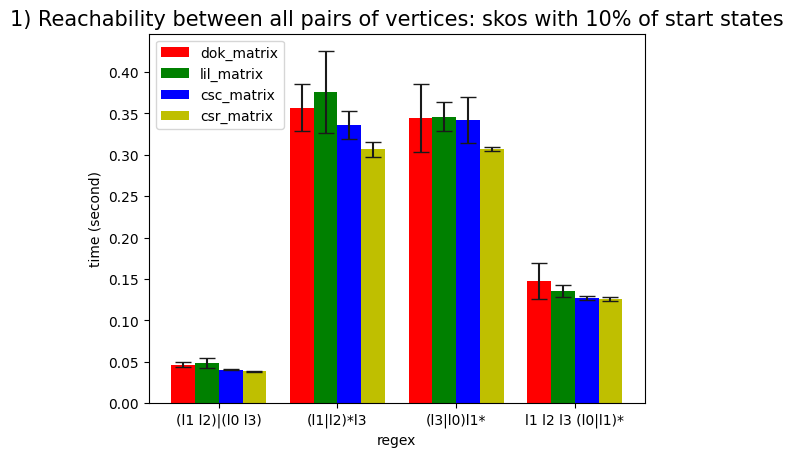

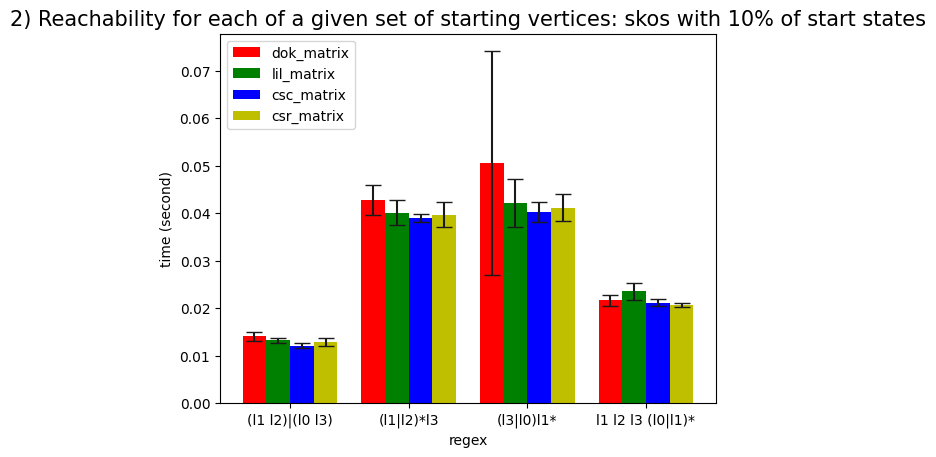

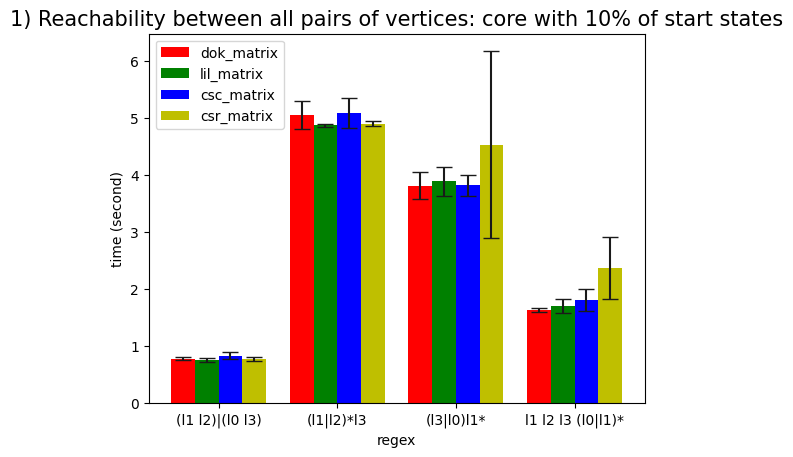

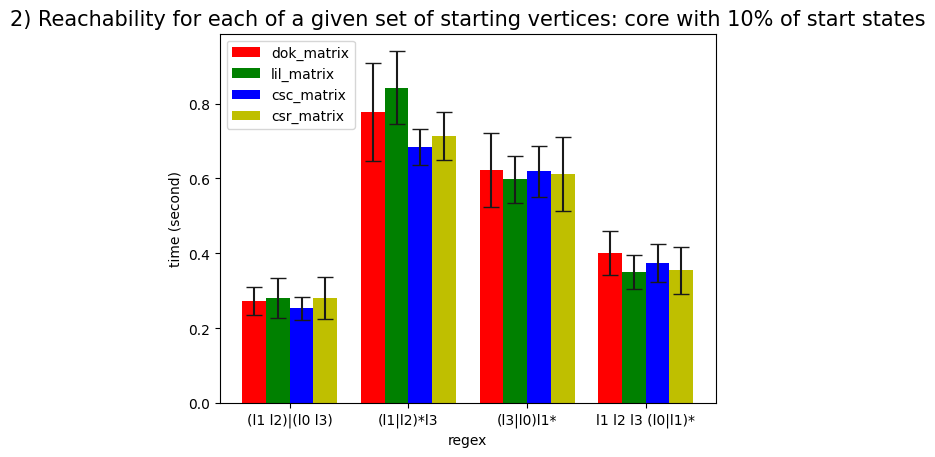

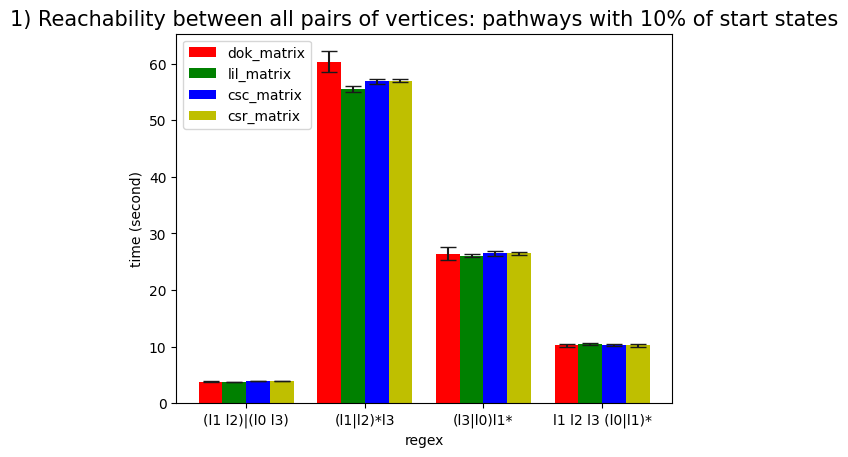

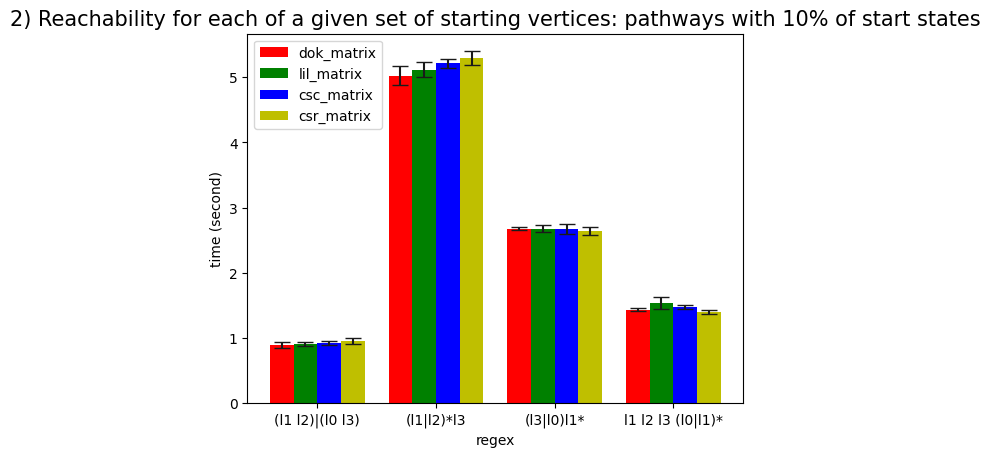

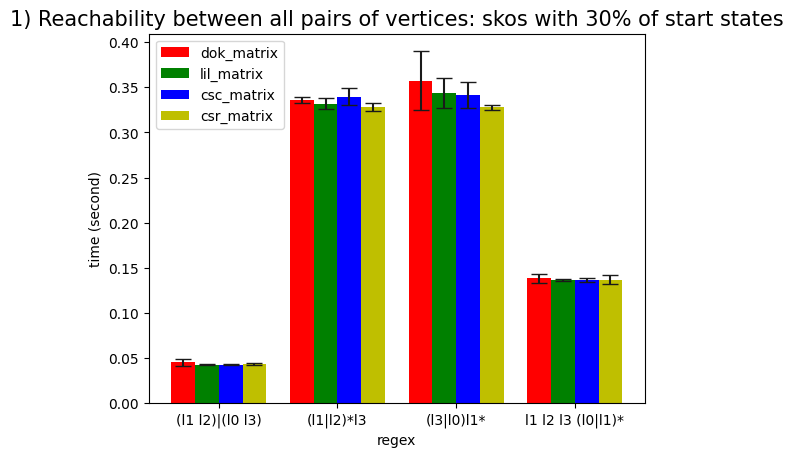

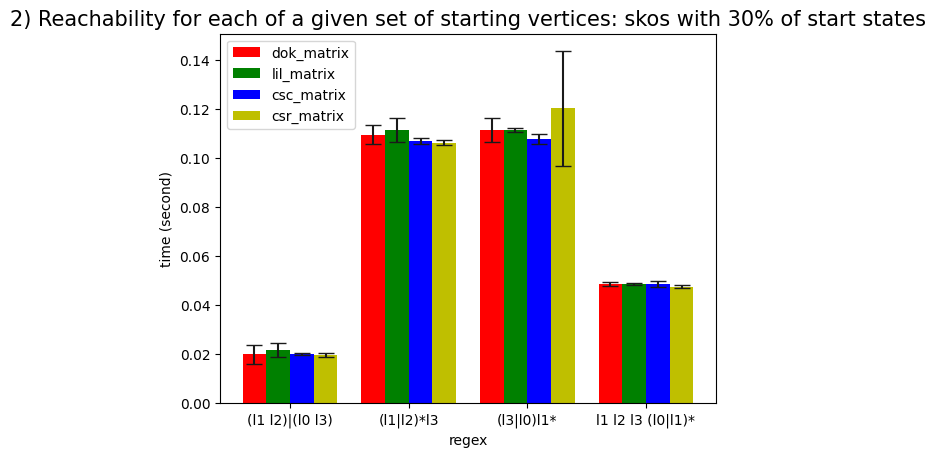

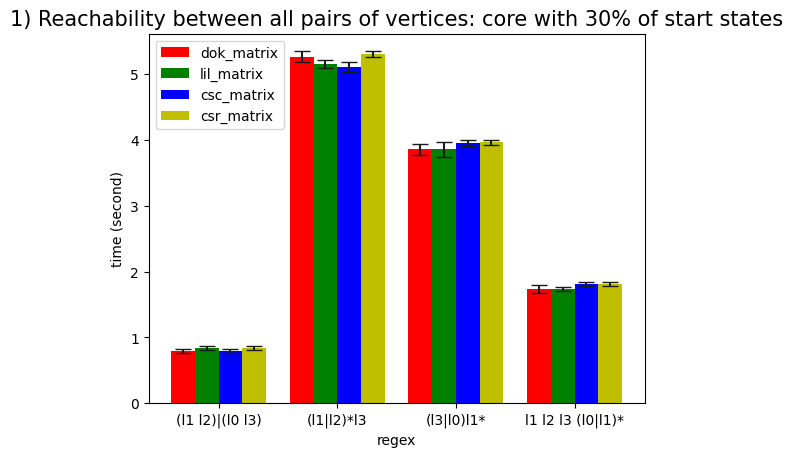

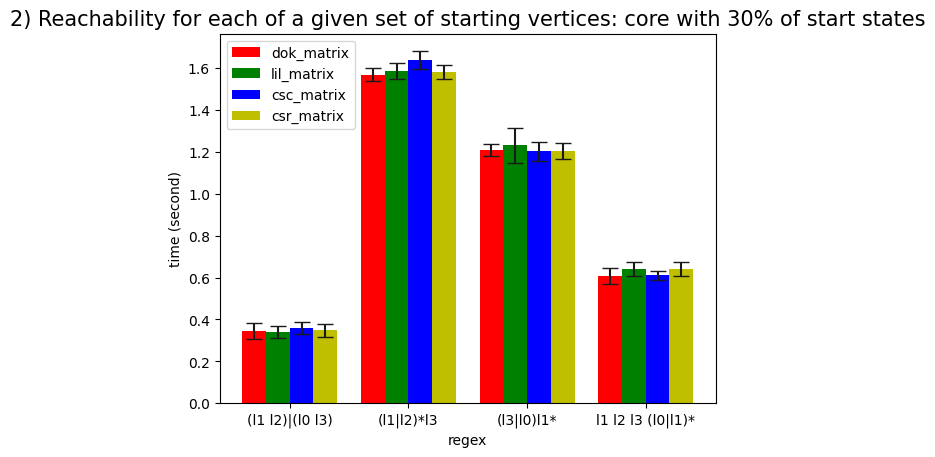

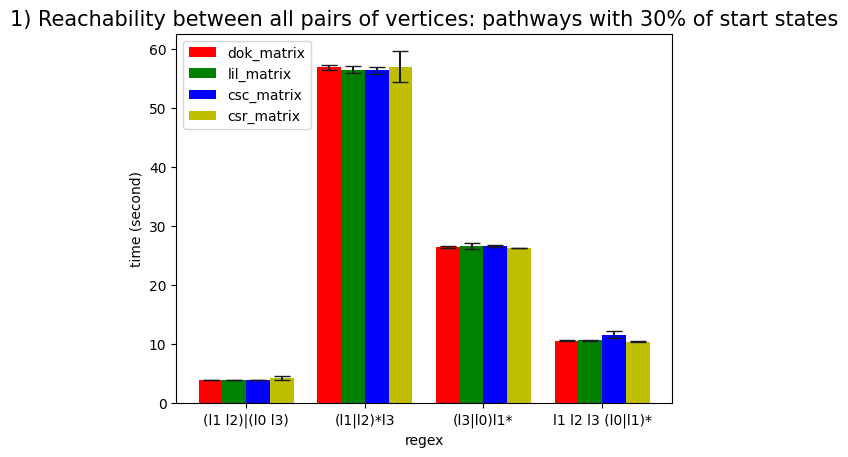

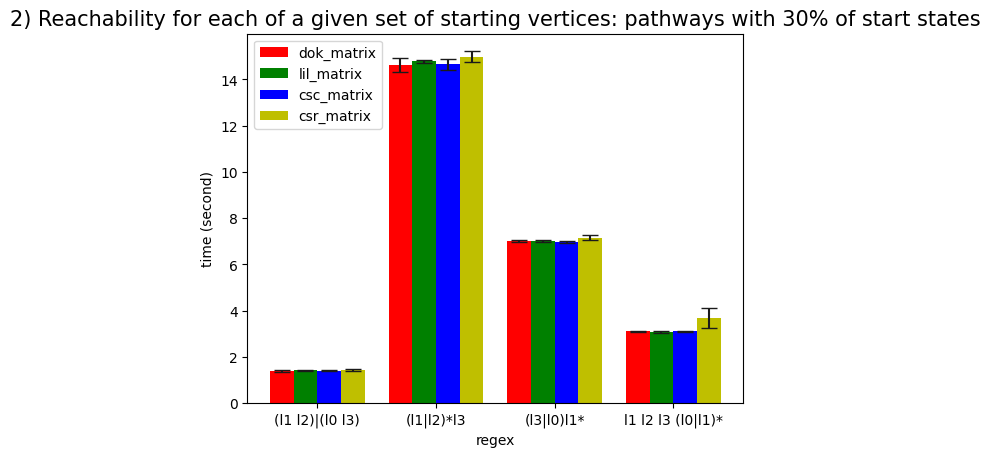

In [7]:
matrices_experiment(tasks, percents_start_states, matrix)

На данных диаграммах представлена зависимость времени выполнения алгоритма в секундах от выбранного регулярного
выражения для разных представлений матриц. Как можно заметить, с увеличением числа стартовых вершин увеличевается и время выполнения программы, не зависимо от того, находим достижимость между всеми парами вершин или для каждой из заданного множества стартовых. Это связана с тем, что производительность работы ms_bfs_based_rpq ухудшается с увеличением множества стартовых вершин. 

Также видно, что при 10% для разных типов матриц результаты схожи, но можно заметить что изначально лучший результат показывает lil_matrix. Тем не менее с ростом числа вершин lil_matrix начинает проигрывать doc_matrix. Из этого можно сделать вывод, что для небольших графов (<=2000 вершин) лучше подходит lil_matrix, но с ростом графа производительность по сравнению с doc_matrix будет падать.

При 30% более подходящими вариантами становятся csr_matrix и doc_matrix, а lil_matrix с ростом количества вершин подходит заметно хуже. Поэтому с ростом отношения числа стартовых вершин ко всем вершинам предпочтение стоит отдавать именно первым двум представлениям матриц.

#### 2. Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

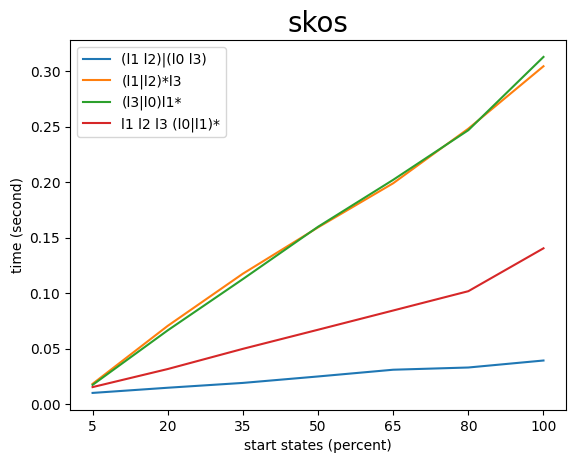

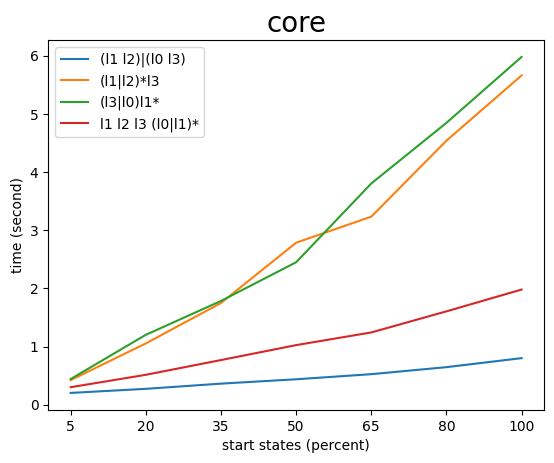

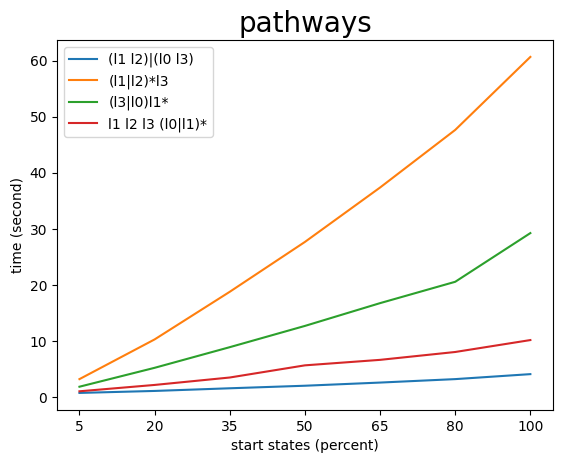

In [15]:
performance_evaluation_experiment(graphs)

Из полученных данных можно сделать вывод, что c ростом числа стартовых вершин растет и время работы алгоритма. Поэтому чем их меньше, тем лучше это скажется на скорость выполнения. Такой эффект можно объяснить прямой зависимостью числа матричных вычислений от количества начальных значений в алгоритме достижимости с регулярными ограничениями с несколькими стартовыми вершинами на основе multiple source BFS через линейную алгебру. Из этого можно сделать выывод, что выгоднее решать задачу для всех пар когда количество стартовых вершин не превышает 5% от числа всех вершин.